We need some test cases for skewed, continuous, distributions. Simulating is not ideal, but at least it will give us some flexibility in offline testing

In [1]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

from tqdm.auto import tqdm
from matplotlib import style

In [90]:
sys.path.append('../../ab_testing_utils/')

In [91]:
import skewed_metric_utils

In [2]:
# additional imports

In [3]:
# pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [4]:
# set plot style
style.use('fivethirtyeight')

In [5]:
# initialize tqdm for pandas
tqdm.pandas()

In [38]:
# We want a distribution which is (very) heavily skewed towards zero.  Let's try an exponential 
r = stats.expon.rvs(size=1000, scale=100000, loc=0)

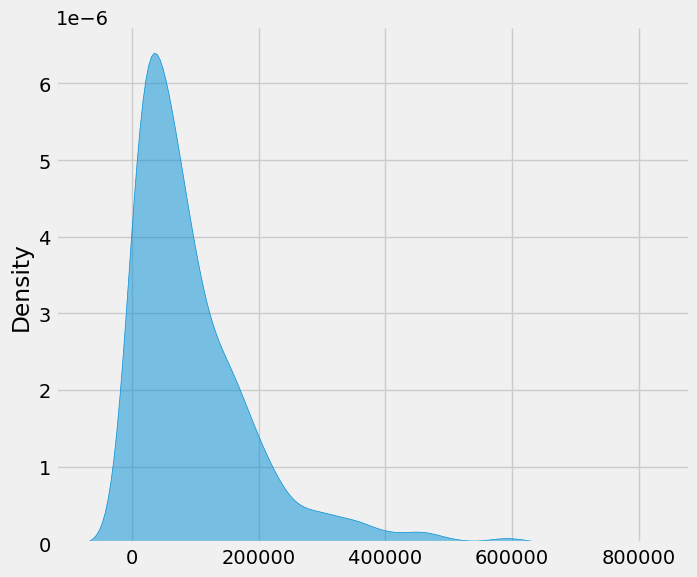

In [39]:
sns.displot(data=r, kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [40]:
np.mean(r)

97662.72631732874

In [41]:
np.median(r)

67753.02160904455

In [79]:
# Hmm, not quite...how about a gamma? 
r = stats.gamma.rvs(size=10000, a=0.01, scale=10000)

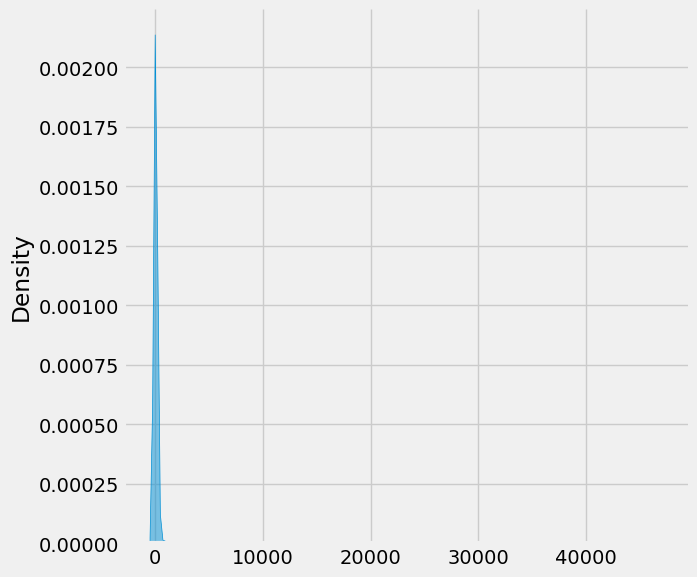

In [80]:
sns.displot(data=r, kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [81]:
# This looks about right
np.mean(r)

109.39545073789847

In [82]:
np.median(r)

2.2598726171816975e-26

In [94]:
# Yeah this will do :) 
df = pd.DataFrame()

In [95]:
df['gamma_sim'] = r

In [96]:
df.head()

,gamma_sim
0,6.642387e-24
1,1.183382e-63
2,1.400390e-72
3,1.618738e-21
4,1.920651e-14


In [97]:
df['gamma_sim'] = df['gamma_sim'].progress_apply(lambda x: np.round(x, 3))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [98]:
df['gamma_sim'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    10000.000000
mean       109.395447
std       1098.454184
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.152100
95%         34.484500
99%       2686.101460
max      46578.325000
Name: gamma_sim, dtype: float64

In [99]:
# Oh yeah, this looks about right :D 

In [100]:
# OK let's try and generate another distribution which is slightly "better" in the sense that the distribution is the same, but there are a number of observations which are bigger

In [101]:
df['variant'] = 'control'

In [112]:
r_2 = stats.gamma.rvs(size=10000, a=0.01, scale=30000)

In [113]:
df_2 = pd.DataFrame()

In [114]:
df_2['gamma_sim'] = r_2
df_2['gamma_sim'] = df_2['gamma_sim'].progress_apply(lambda x: np.round(x, 3))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [115]:
df_2['variant'] = 'exposure'

In [116]:
df_all = pd.concat([df, df_2])

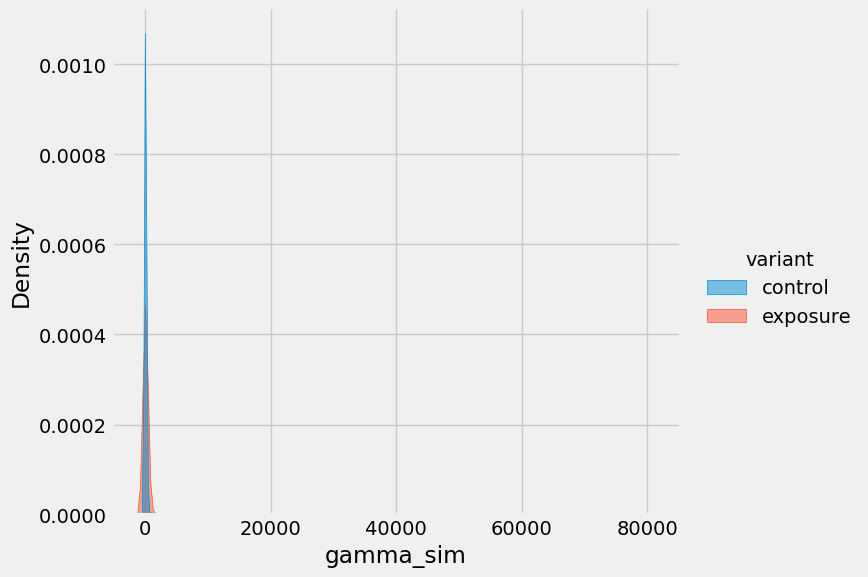

In [117]:
sns.displot(data=df_all, x='gamma_sim', hue='variant', kind='kde', fill=True, alpha=0.5, height=6, aspect=1.2)

In [118]:
df_all.groupby('variant')['gamma_sim'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
variant,,,,,,,,,,,
control,10000.0,109.395447,1098.454184,0.0,0.0,0.0,0.0,0.1521,34.4845,2686.10146,46578.325
exposure,10000.0,282.447563,2615.922636,0.0,0.0,0.0,0.0,0.4748,99.4799,8372.78082,79721.668


In [ ]:
sns.boxplot(data=df_all, x='gamma_sim', hue='variant', height=6, aspect=1.2)